# Test NEWT for WBGT calculation

In [78]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy

import numpy as np
import pandas as pd
import os, glob, re, sys
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

In [15]:
sys.path.append('../atmos/')
import atmos
from atmos import thermo

In [21]:
print(thermo.pseudo_wet_bulb_temperature.__doc__)
print(thermo.isobaric_wet_bulb_temperature.__doc__)


    Computes pseudo wet-bulb temperature.

    Pseudo wet-bulb temperature is the temperature of a parcel of air lifted
    adiabatically to saturation and then brought pseudoadiabatically at
    saturation back to its original pressure. It is always less than the
    isobaric wet-bulb temperature.

    See https://glossary.ametsoc.org/wiki/Wet-bulb_temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        polynomial (bool, optional): flag indicating whether to use polynomial
            fits to pseudoadiabats (default is True)

    Returns:
        Tw (float or ndarray): pseudo wet-bulb temperature (K)

    

    Computes isobaric wet-bulb temperature.

    Isobaric wet-bulb temperature is the temperature of a parcel of air cooled
   

In [22]:
print(thermo.wet_bulb_temperature.__doc__)



    Computes wet-bulb temperature for specified saturation process.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        saturation (str, optional): saturation process (valid options are
            'pseudo' or 'isobaric'; default is 'pseudo')
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        polynomial (bool, optional): flag indicating whether to use polynomial
            fits to pseudoadiabats (default is True)

    Returns:
        Tw: wet-bulb temperature (K)

    


# Test run Tw calculation

In [32]:
thermo.wet_bulb_temperature(1030*100,30+273.15,.008, saturation ='isobaric') - 273.15

18.373963931812114

In [55]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) 

len(T), len(q)

(60, 49)

In [69]:
T_arr = np.array([T]*len(q) ) 
T_arr

array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])

In [72]:
q_arr = np.array([q]*len(T) ).T
q_arr

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])

In [85]:
print(q_arr.shape, T_arr.shape)

(49, 60) (49, 60)


In [81]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,q_arr, saturation ='isobaric') - 273.15

<a list of 9 text.Text objects>

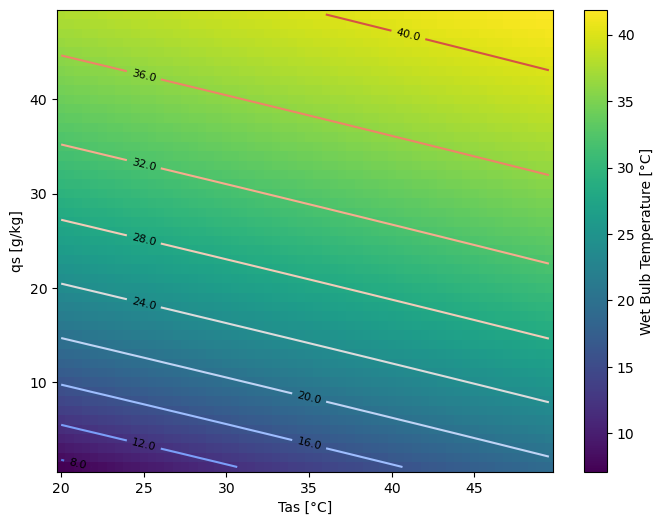

In [132]:

Tw_da = xr.DataArray(Tw_arr, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [137]:

WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (qs: 49, Tas: 60)>
array([[10.98004697, 11.3022496 , 11.62322882, ..., 27.72374161,
        27.9934836 , 28.26256355],
       [11.79490711, 12.11072504, 12.42538592, ..., 28.26532986,
        28.5316181 , 28.79728015],
       [12.58008005, 12.88983999, 13.19850701, ..., 28.79141525,
        29.05442054, 29.31683326],
       ...,
       [31.82937939, 32.03437095, 32.23923892, ..., 43.33602353,
        43.53499052, 43.73386787],
       [32.08987093, 32.29402526, 32.4980606 , ..., 43.55519728,
        43.7535401 , 43.95179628],
       [32.34629403, 32.54963659, 32.75286457, ..., 43.77146963,
        43.96920449, 44.16685556]])
Coordinates:
  * qs       (qs) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 45.0 46.0 47.0 48.0 49.0
  * Tas      (Tas) float64 20.0 20.5 21.0 21.5 22.0 ... 47.5 48.0 48.5 49.0 49.5
Attributes:
    units:    °C

<a list of 7 text.Text objects>

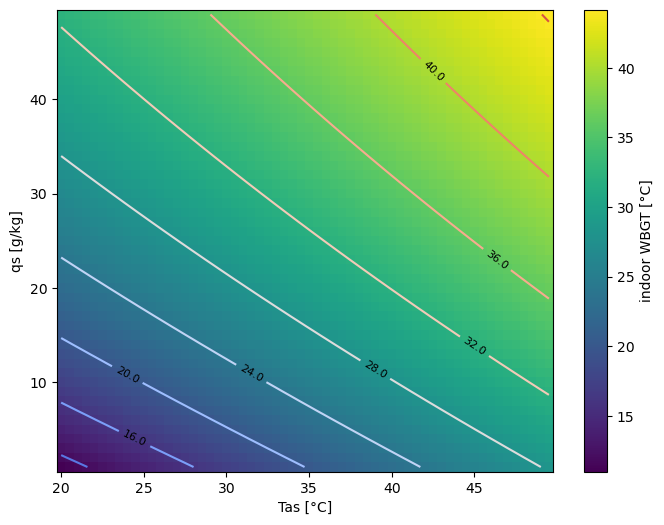

In [138]:

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


# Test on a dataarray

In [ ]:
# open da tasmax (small subregion) or make dummy dd

# open da qs (small subregion) or make dummy dd

# check / convert units 

# run NEWT on it or make wrapper fxn to do so 